<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/Mining_frequent_subgraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['cobol_pullrequests.csv']))

Saving cobol_pullrequests.csv to cobol_pullrequests (2).csv


In [ ]:

df


,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files
0,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:38:18 UTC,"{""action"":""closed"",""number"":3,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
1,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:28:12 UTC,"{""action"":""opened"",""number"":3,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
2,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 16:19:54 UTC,"{""action"":""closed"",""number"":4,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
3,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:37:56 UTC,"{""action"":""opened"",""number"":4,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
4,PullRequestEvent,mavimaec,vimaec/g3d,2021-11-19 20:40:52 UTC,"{""action"":""closed"",""number"":8,""pull_request"":{...","""COBOL""","""closed""","""mavimaec""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/8""",2,113,702,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-05-14 03:43:29 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,688,1,39
1329,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-06 17:56:00 UTC,"{""action"":""closed"",""number"":127,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1330,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-11-30 22:12:33 UTC,"{""action"":""opened"",""number"":127,""pull_request""...","""COBOL""","""opened""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1331,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-09 04:01:35 UTC,"{""action"":""closed"",""number"":128,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,5,1,1


In [ ]:
df['login'] = df['login'].apply(lambda x: 'User: '+x)
df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

In [ ]:
# Build the adjacency matrix
am = pd.crosstab(df['login'], df['name']).astype(float)
idx = am.columns.union(am.index)
am = am.reindex(index = idx, columns=idx, fill_value=0.0)

Graph with 262 nodes and 192 edges


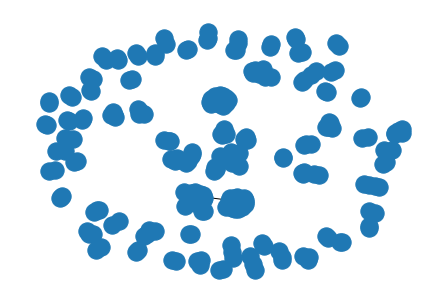

In [ ]:
G = nx.from_numpy_matrix(am.to_numpy())
plt.figure(1)
nx.draw(G)
print(nx.info(G))

Graph with 262 nodes and 664 edges


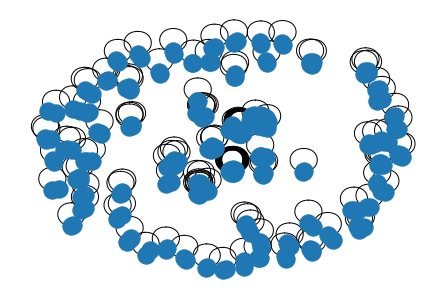

In [ ]:
matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def  cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = am.loc[i].to_numpy()[:repo_len]
        aux_vector_b = am.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        # print(i, j, score)
        aux_matrix.at[i, j] = score

#%%
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        am.at[row, column] = aux
        # if (aux == am.at[row, column]) ==  False:
        #     print(aux, row, column)

# %%
# Build graph from matrix, after user-user connections
G = nx.from_numpy_matrix(am.to_numpy())
plt.figure(2)
nx.draw(G)
print(nx.info(G))

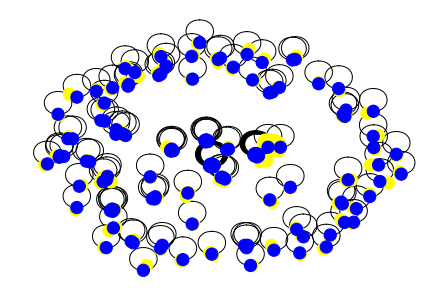

In [ ]:
# Initialise the grah
G = nx.MultiGraph()


# Save edges with their weights
edges = []

for row in am.index:
    vector = am.loc[row].to_numpy()
    for i, j in zip(vector, am.columns):
        if i > 0:
            edges.append((row[6:],j[6:],i)) # for nx.Graph() use edges.append((row[6:],j[6:],{'weight': i}))
 
# Save nodes
nodes = []

for name in am.index:
    if name.startswith('User: '):
        nodes.append((name[6:],{"color": "blue"})) #Users are blue
    elif name.startswith('Repo: '):
        nodes.append((name[6:],{"color": "yellow"})) #Repos are yellow

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)    # for nx.Graph() use edges.add_edges_from(edges)
pos = nx.spring_layout(G, seed=52)  # positions for all nodes
# Set nodes colors, blue for users, yellow for repos.
colors = nx.get_node_attributes(G, "color")
node_colors = [colors.get(node) for node in G.nodes()]

# List all users #https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling
users = [key for key,value in nx.get_node_attributes(G,'color').items() if value == 'blue']
labels = {}    
for node in G.nodes():
    if node in users:
        labels[node] = node

#%%
fig = plt.figure(3)
nx.draw(G,pos = pos, node_color=node_colors, node_size=150, with_labels=False)
#nx.draw_networkx_labels(G,pos,labels,font_size=12)
plt.show()

In [ ]:
nx.write_edgelist(G, "test_edgelist", delimiter=' ', data=False)

In [ ]:
am.shape

(262, 262)

In [ ]:
!pip install gspan-mining

In [ ]:
from gspan_mining.config import parser
from gspan_mining.main import main

In [ ]:
args_str = '-s 2 -d True -l 5 -p True -w True test_edgelist'

In [ ]:
FLAGS, _ = parser.parse_known_args(args=args_str.split())

In [ ]:
gs = main(FLAGS)

Read:	0.01 s
Mine:	0.0 s
Total:	0.01 s
